In [225]:
import sys
import rootpath
sys.path.append(rootpath.detect())

import numpy as np
import matplotlib.pyplot as plt
from testsuite.utilities import Pareto_split

from itertools import combinations as Combinations
from numpy.linalg import svd


import matplotlib

matplotlib.rcParams['figure.figsize'] = (8, 8)

In [226]:
def _get_extrusions(pair):
    if pair.ndim <2:
        pair = pair.reshape(1, -1)
    n_points, n_dims = pair.shape
    return [np.vstack((*c, np.zeros_like(c[0]))) for c in Combinations(pair, n_dims - 1)]

def point_vector_distances(points, vector):
    """
    calculates the distance of all points in points to the nearest
    point in vector
    """
    # argument format checks
    if points.ndim != 2:
        # ensures single point passed is of shape (1, n) rather than (n,)
        points = points.reshape(1, -1)
    assert points.shape[1] == vector.shape[1]

    points_hat = (points.T / np.linalg.norm(points, axis=1)).T
    len_vector = np.linalg.norm(vector)
    vector_hat = vector / len_vector
    cs = vector_hat @ points_hat.T
    return np.sqrt(1 - cs * cs) * len_vector

def _side(points, a):
    a = a.reshape(-1)

    plane = np.vstack((np.zeros_like(points[0]), points))
    e = (plane- plane.mean(axis=0))
    U, s, vt = svd(e)

    # check the span of the plane is only d-1
    np.testing.assert_almost_equal(s[-1], 0)

    # vector normal to the plane
    normal_vector = vt[-1]

    sign_a = np.dot(normal_vector, a.T)>0.

    return sign_a >0.


def _plane_side_comparison(plane, a, b):
    """
    calculates whether points a and b are on the same "side" of plane

    :param plane: np.ndarray(d-1, d)
           plane formed of d-1 points, one of which is the origin
    :param a: np.array(1, d)
           first point to compare
    :param b: np.array(1, d)
           second point to compare

    :return: bool
             True if a and b lie on the same side of plane False otherwise.
    """
    a = a.reshape(-1)
    b = b.reshape(-1)

    e = (plane- plane.mean(axis=0))
    U, s, vt = svd(e)

    # check the span of the plane is only d-1
    np.testing.assert_almost_equal(s[-1], 0)

    # vector normal to the plane
    normal_vector = vt[-1]

    sign_a = np.dot(normal_vector, a.T)>0.
    sign_b = np.dot(normal_vector, b.T)>0.

    # check whether they are the same side
    return sign_a == sign_b

def _find_intersections(combinations, dmv):
    # find which combinations in combos are intersected by dmv
    intersections = np.ones(np.shape(combinations)[0], dtype=bool)
    for i, comb in enumerate(combinations):
        midpoint = np.mean(comb, axis=0)

        # get the cones formed from the origin and combination of points
        extrusions = _get_extrusions(np.vstack(comb))

        # find the extrusions for which the mid-point and dmv vector are on
        # the same side
        for j, extrusion in enumerate(extrusions):
            if not _plane_side_comparison(extrusion, dmv, midpoint):
                intersections[i] = False
    return intersections

def _dm_choice(points, dmv):
    """
    chooses set of d points, the surface between which is intersected by
    the ray dmv, with the smallest sum of squared distances between each
    point in the set and its nearest point on the vector dmv

    :param points: np.ndarray (m, d)
           Array of m d-dimensional points.   
    :param dmv: np.ndarray(d,)
           vector representing the decision makers ray of preference

    :return: np.array(d, d) OR np.array(1, d)
           chosen set of points which enclose dmv, or single closest point
           if no set encloses dmv
           
    """
    p, d = Pareto_split(points)
    
#     combinations = np.array([np.vstack((p[-1], c)) for c in Combinations(p, p.shape[1]-1)])
    combinations = np.array(list(Combinations(p, p.shape[1])))

    intersections = _find_intersections(combinations, dmv)

    # choose the combination with the smallest sum of squared disitances to
    # the DM's preference vector.
    intersecting_combos = combinations[intersections]
    try:
        choice_ind = np.argmin([sum_point_vector_distances(comb, dmv)
                                for comb in intersecting_combos])
        return intersecting_combos[choice_ind]
    except ValueError:
        # if no pair is intersected by the dmv return the nearest point
        return points[np.argmin(point_vector_distances(points, dmv))]

def sum_point_vector_distances(points, vector):
    """
    sum of squared distances between points and vector
    """
    return np.sum(point_vector_distances(points, vector))

In [227]:
np.random.seed(4)
x_2d = abs(np.random.multivariate_normal(np.zeros(2), np.diag(np.ones(2)*5), 40))
x_2d = np.abs((x_2d.T/np.linalg.norm(x_2d, axis=1)).T + np.random.randn(*x_2d.shape)/5)
x_2d.shape

(40, 2)

In [228]:
dmv = np.array([2.5, 1]).reshape(1, -1)
dmv = dmv/np.linalg.norm(dmv)

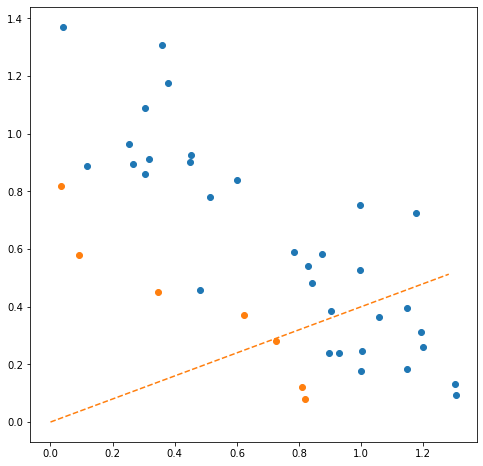

In [229]:
fig = plt.figure()
ax = fig.gca()

p2d, d2d = Pareto_split(x_2d)
ax.scatter(*d2d.T, c="C0")
ax.scatter(*p2d.T, c="C1")

magnitude = np.max(np.linalg.norm(x_2d, axis=1))
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")

In [230]:
best = _dm_choice(x_2d, dmv)
best.shape

(2, 2)

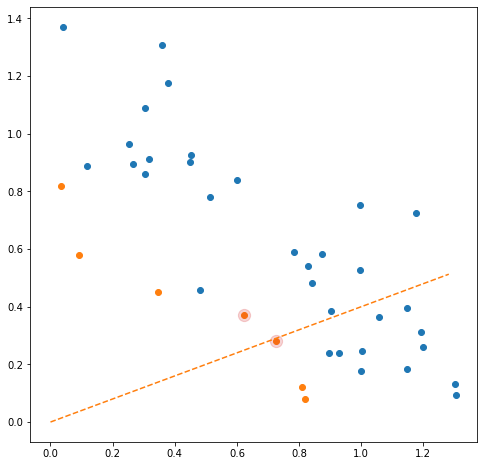

In [231]:
ax.scatter(*best.T, c="C3", s=150, alpha=0.2)
fig

In [232]:
new_point = (best[1]*0.9+np.random.randn(*best[1].shape)/15).reshape(1, -1)
new_point.shape

(1, 2)

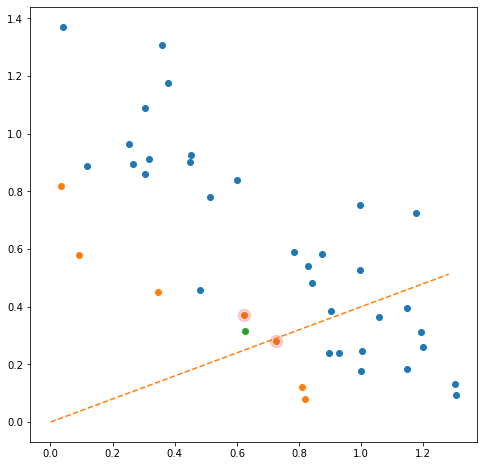

In [233]:
ax.scatter(*new_point.T, c="C2")
fig

In [234]:
old_best = sum_point_vector_distances(best, dmv)
old_best

0.1652320680439569

In [235]:
new_combinations = [np.vstack((new_point, c)) for c in Combinations(p2d, 1)]
new_combinations.append(best)

In [236]:
new_intersections = _find_intersections(new_combinations, dmv)
new_intersections

array([False, False,  True, False,  True,  True, False,  True])

In [237]:
new_combs = np.array(new_combinations)[new_intersections]
new_combs = np.vstack((new_combs, best.reshape(1,*best.shape)))
new_combs.shape

(5, 2, 2)

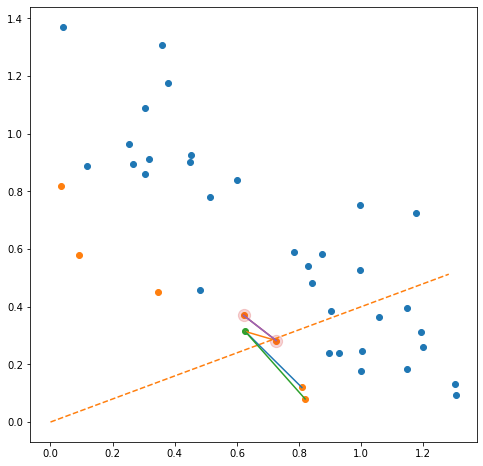

In [238]:
for i, a in enumerate(new_combs):
    ax.plot(*a.T, c="C{}".format(i))
fig

In [239]:
new_best = new_combs[np.argmin([sum_point_vector_distances(nc, dmv) for nc in new_combs])]

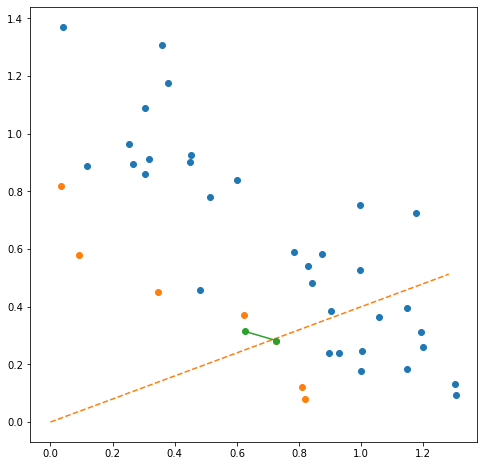

In [240]:
fig = plt.figure()
ax = fig.gca()

p2d, d2d = Pareto_split(x_2d)
ax.scatter(*d2d.T, c="C0")
ax.scatter(*p2d.T, c="C1")

magnitude = np.max(np.linalg.norm(x_2d, axis=1))
ax.plot(*np.vstack((np.zeros_like(dmv), dmv*magnitude)).T, c="C1", linestyle="--")
ax.plot(*new_best.T, c="C2", marker="o")

In [111]:
p2d

array([[0.34464399, 0.4499676 ],
       [0.6214372 , 0.37011784],
       [0.80909845, 0.11982476],
       [0.09271592, 0.58023627],
       [0.7261286 , 0.28271975],
       [0.81944047, 0.08006334],
       [0.03353237, 0.81758679]])

In [156]:
dmv_sides = {i:np.vstack(c) for i, c  in enumerate(Combinations(p2d, 2))}

In [196]:
import numpy as np
from itertools import combinations

test_points = "abcdefg" 
n_combinations = 3

ans = {tuple([combi[0] for combi in comb]): tuple([combi[1] for combi in comb]) for comb in combinations(enumerate(test_points), n_combinations)}
ans

{(0, 1, 2): ('a', 'b', 'c'),
 (0, 1, 3): ('a', 'b', 'd'),
 (0, 1, 4): ('a', 'b', 'e'),
 (0, 1, 5): ('a', 'b', 'f'),
 (0, 1, 6): ('a', 'b', 'g'),
 (0, 2, 3): ('a', 'c', 'd'),
 (0, 2, 4): ('a', 'c', 'e'),
 (0, 2, 5): ('a', 'c', 'f'),
 (0, 2, 6): ('a', 'c', 'g'),
 (0, 3, 4): ('a', 'd', 'e'),
 (0, 3, 5): ('a', 'd', 'f'),
 (0, 3, 6): ('a', 'd', 'g'),
 (0, 4, 5): ('a', 'e', 'f'),
 (0, 4, 6): ('a', 'e', 'g'),
 (0, 5, 6): ('a', 'f', 'g'),
 (1, 2, 3): ('b', 'c', 'd'),
 (1, 2, 4): ('b', 'c', 'e'),
 (1, 2, 5): ('b', 'c', 'f'),
 (1, 2, 6): ('b', 'c', 'g'),
 (1, 3, 4): ('b', 'd', 'e'),
 (1, 3, 5): ('b', 'd', 'f'),
 (1, 3, 6): ('b', 'd', 'g'),
 (1, 4, 5): ('b', 'e', 'f'),
 (1, 4, 6): ('b', 'e', 'g'),
 (1, 5, 6): ('b', 'f', 'g'),
 (2, 3, 4): ('c', 'd', 'e'),
 (2, 3, 5): ('c', 'd', 'f'),
 (2, 3, 6): ('c', 'd', 'g'),
 (2, 4, 5): ('c', 'e', 'f'),
 (2, 4, 6): ('c', 'e', 'g'),
 (2, 5, 6): ('c', 'f', 'g'),
 (3, 4, 5): ('d', 'e', 'f'),
 (3, 4, 6): ('d', 'e', 'g'),
 (3, 5, 6): ('d', 'f', 'g'),
 (4, 5, 6): ('

In [219]:
from itertools import combinations 

alpha = "abcde" 
n_combinations = 3

ans = {tuple([c_i[0] for c_i in comb]): tuple([c_i[1] for c_i in comb]) 
       for comb in combinations(enumerate(alpha), n_combinations)}

In [221]:
%%timeit
ans = {tuple([c_i[0] for c_i in comb]): tuple([c_i[1] for c_i in comb]) 
       for comb in combinations(enumerate(alpha), n_combinations)}

9.92 µs ± 285 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [223]:
%%timeit
D = {(k:=list(zip(*comb)))[0]:k[1] for comb in combinations(enumerate(alpha), n_combinations)}

6.66 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [224]:
%%timeit
ans = {key: tuple([alpha[i] for i in key]) for key in combinations(range(len(alpha)), n)}

5.69 µs ± 97.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
np.linalg.svd